In [1]:
# import necessar libraries
import pandas as pd
import numpy as np

import code.data_preparation as dp
import code.visualizations as viz

import warnings
warnings.filterwarnings(action='ignore')

# read data
data = pd.read_csv("data/training_set_features.csv", index_col = 0)
vac = pd.read_csv("data/training_set_labels.csv", index_col = 0)

all_data = data.merge(vac['h1n1_vaccine'], left_index=True, right_index=True)

all_data.drop(['doctor_recc_seasonal',
               'opinion_seas_vacc_effective',
               'opinion_seas_risk',
               'opinion_seas_sick_from_vacc'], 
              axis = 1,
              inplace=True)

# removed due to too many missing values
all_data.drop(['health_insurance',
               'employment_industry',
               'employment_occupation'], 
              axis = 1,
              inplace=True)

# replace missing values for three questions
# missing = "3 - don't know"
all_data.opinion_h1n1_vacc_effective.fillna(3, inplace=True)
all_data.opinion_h1n1_risk.fillna(3, inplace=True)
all_data.opinion_h1n1_sick_from_vacc.fillna(3, inplace=True)

X = all_data.copy()
y = X.pop('h1n1_vaccine')

In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

In [3]:
# import libraries for columns transformation
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

In [4]:
# instantiate encoders
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
le = LabelEncoder()

In [5]:
# steps for labeling multi-binary columns
# missing values assigned to a new value
X_train_labeled = X_train.copy()
X_test_labeled = X_test.copy()

for c in X.columns:
    X_train_labeled[c] = le.fit_transform(X_train[c].astype('str'))
    X_test_labeled[c] = le.transform(X_test[c].astype('str'))

In [6]:
# instantiate columntransformer
# transfer only age_group column to test out the pipeline
ct = ColumnTransformer([('age', ohe, ['age_group'])],
                       remainder='passthrough')

In [7]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline

# instantiate pipeline using column transformer and baseline model
pipe = Pipeline(steps=[('ct', ct),
                       ('rfc', RandomForestClassifier(random_state=1))])

In [8]:
pipe.fit(X_train_labeled, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('age',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['age_group'])])),
                ('rfc', RandomForestClassifier(random_state=1))])

In [9]:
pipe.score(X_train_labeled, y_train)

0.9999500748876685

In [10]:
pipe.score(X_test_labeled, y_test)

0.8336079077429983

CV score:     83.31%
X-test score: 83.36%
RMSE:         0.4079

X-test score

              precision    recall  f1-score   support

           0       0.85      0.96      0.90      5263
           1       0.71      0.36      0.48      1414

    accuracy                           0.83      6677
   macro avg       0.78      0.66      0.69      6677
weighted avg       0.82      0.83      0.81      6677



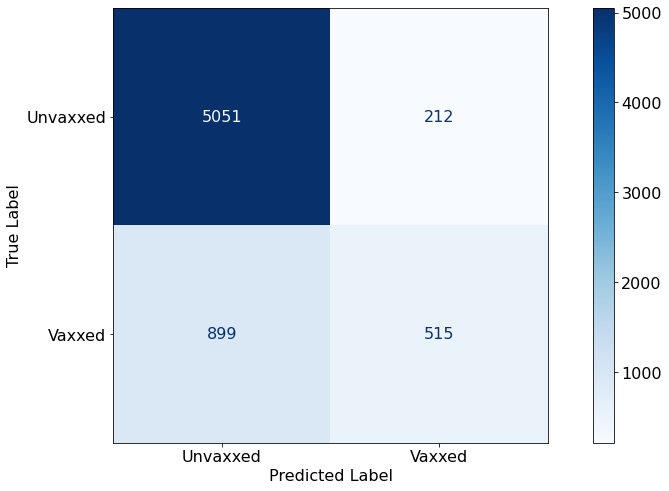

In [11]:
# summarization of scores and confusion matrix of baseline model
dp.scores2(X_train_labeled, y_train, X_test_labeled, y_test, pipe)
viz.plot_cm(X_train_labeled, y_train, X_test_labeled, y_test, pipe)

In [12]:
from sklearn.model_selection import GridSearchCV

# instantiate grid search for hyperparameter tuning
param = {'rfc__max_depth': range(2,10)}
gs = GridSearchCV(estimator=pipe,
                  param_grid=param,
                  cv=3)

gs.fit(X_train_labeled, y_train)
gs.best_params_

{'rfc__max_depth': 9}

CV score:     83.11%
X-test score: 83.12%
RMSE:         0.4108

X-test score

              precision    recall  f1-score   support

           0       0.84      0.97      0.90      5263
           1       0.76      0.30      0.43      1414

    accuracy                           0.83      6677
   macro avg       0.80      0.64      0.66      6677
weighted avg       0.82      0.83      0.80      6677



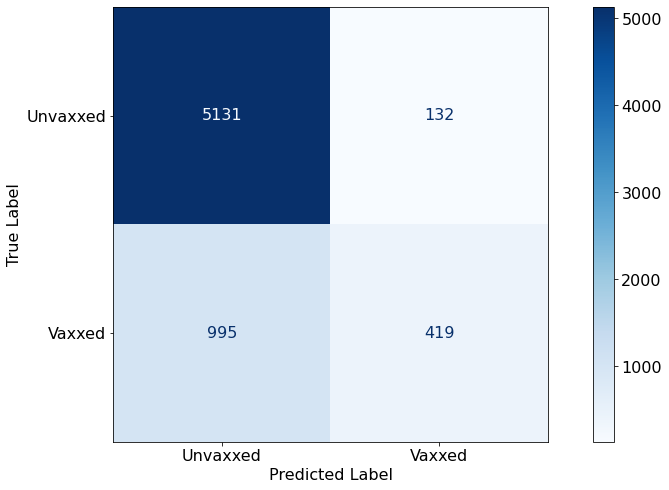

In [13]:
# summarization of scores and confusion matrix of the model with hyperparameter tuned
pipe2 = Pipeline(steps=[('ct', ct),
                       ('rfc', RandomForestClassifier(random_state=1, max_depth = 9))])
dp.scores2(X_train_labeled, y_train, X_test_labeled, y_test, pipe2)
viz.plot_cm(X_train_labeled, y_train, X_test_labeled, y_test, pipe2)

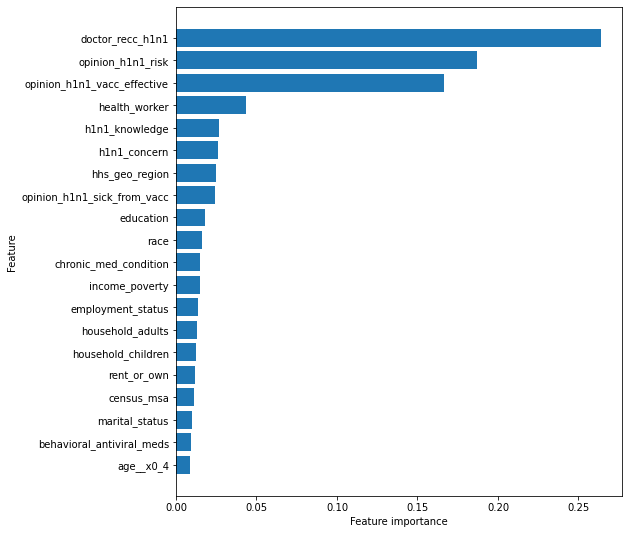

In [14]:
# graph of the features sorted by the impact level on the analysis
# using hyperparameter-tuned model
import matplotlib.pyplot as plt
%matplotlib inline

# extract feature importance scores and feature names
# then merge them
feat_impt = pd.concat([pd.DataFrame(pipe2.steps[1][1].feature_importances_, columns = ['FI_score']),
                       pd.DataFrame(pipe2.steps[0][1].get_feature_names(), columns = ['Features'])],
                      axis = 1)

# sort descending by importance
feat_impt.sort_values(by = 'FI_score', inplace=True)

# print graph of the top 20 important features
plt.figure(figsize=(8,9))
plt.barh(range(20), feat_impt.FI_score[-20:], align='center') 
plt.yticks(np.arange(20), feat_impt.Features[-20:]) 
plt.xlabel('Feature importance')
plt.ylabel('Feature');